In [1]:
# analysis of the Carlini-Wagner and PGD attacks on SPEECHCOMMANDS

In [2]:
%load_ext autoreload
%autoreload 2
# Disable jedi autocompleter
%config Completer.use_jedi = False

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
# mpl.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
from pprint import pprint
import glob
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import trange, tqdm

In [5]:
import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# manually set cuda device
torch.cuda.set_device(1)
device = 'cpu'
print(device)

cpu


In [7]:
### 0 - prelims
# load all the models
## classic model
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2).squeeze()
    
# FGN model    
class FGN_M5(nn.Module):
    
    # changes:
    # nn.Conv1d -> fgnl.FGN_Conv1d
    # added g to conv inputs and outputs
    # make sure you pass g through the same pooling steps as x
    
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.fgn_conv1 = fgnl.FGN_Conv1d(in_channels=n_input, out_channels=n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.fgn_conv2 = fgnl.FGN_Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.fgn_conv3 = fgnl.FGN_Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fgn_conv4 = fgnl.FGN_Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        
    def forward(self, x):
        x, g = self.fgn_conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        g = self.pool1(g)
        x, g = self.fgn_conv2(x, g)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        g = self.pool2(g)
        x, g = self.fgn_conv3(x ,g)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        g = self.pool3(g)
        x, _ = self.fgn_conv4(x, g)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2).squeeze()


# pretrained models paths
save_path = '/home/felix/Research/Adversarial Research/FGN---Research/Experiments/sample_SPEECHCOMMANDS_models/'

classic_model_name= 'sample_classic_model_SPEECHCOMMANDS'
fgn_model_name = 'sample_FGN_model_SPEECHCOMMANDS'


# define and load the models
# classic model
classic_model = M5()
classic_model.load_state_dict(torch.load(save_path+classic_model_name+'_state_dict.pth'))
classic_model.to(device)

# fgn model trained from scratch
fgn_model_from_scratch = FGN_M5()
fgn_model_from_scratch.load_state_dict(torch.load(save_path+fgn_model_name+'_state_dict.pth'))
fgn_model_from_scratch.to(device)

# converted fgn model (no retraining)
fgn_model_converted_no_retraining = FGN_M5()
fgn_model_converted_no_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_model_SPEECHCOMMANDS'+'_state_dict.pth'))
fgn_model_converted_no_retraining.to(device)

# converted and retrained 1 epoch fgn model
fgn_model_converted_fast_retraining = FGN_M5()
fgn_model_converted_fast_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_fast_retrained_model_SPEECHCOMMANDS'+'_state_dict.pth'))
fgn_model_converted_fast_retraining.to(device)

# converted and retrained 21 epoch fgn model
fgn_model_converted_long_retraining = FGN_M5()
fgn_model_converted_long_retraining.load_state_dict(torch.load(save_path+'sample_FGN_converted_long_retrained_model_SPEECHCOMMANDS'+'_state_dict.pth'))
fgn_model_converted_long_retraining.to(device)


# set all models to eval mode
classic_model.eval()
fgn_model_from_scratch.eval()
fgn_model_converted_no_retraining.eval()
fgn_model_converted_fast_retraining.eval()
fgn_model_converted_long_retraining.eval()

FGN_M5(
  (fgn_conv1): FGN_Conv1d(
    (Conv1d): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  )
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv2): FGN_Conv1d(
    (Conv1d): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  )
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv3): FGN_Conv1d(
    (Conv1d): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  )
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fgn_conv4): FGN_Conv1d(
    (Conv1d): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  )
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): Ma

In [8]:
model_name_pairs = {'Classic': classic_model,
                    'FGN_from_scratch': fgn_model_from_scratch,
                    'FGN_converted (no retraining)': fgn_model_converted_no_retraining,
                    'FGN_converted (fast retraining)': fgn_model_converted_fast_retraining,
                    'FGN_converted (long retraining)': fgn_model_converted_long_retraining
                   }

In [9]:
### 1 - Verify location of attacks
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1637192331.3530319/' # 0_24, prob old
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1637192253.3900166/' # contains nothing
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1633722950.2487264/' # prob old
# attack_results_dir = '/scratch/felix/FGN---Results/adversarial_attacks_results/1633715707.3646119/' # prob old
# attack_results_dir = '/scratch/felix/FGN---Results/1637192253.3900166/' # 0 files

attack_results_dir_0_24 = '/scratch/felix/FGN---Results/1637192331.3530319/'
# start_0_stop_24

attack_results_dir_24_48 = '/scratch/felix/FGN---Results/1637433413.7582006/'
# start_24_stop_48

attack_results_dir_48_none = '/scratch/felix/FGN---Results/1637624970.2306073/'
# start_48_stop_none 

In [10]:
attack_results_dir_list_0_24 = sorted(glob.glob(attack_results_dir_0_24+'/*', recursive = True))
attack_results_dir_list_24_48 = sorted(glob.glob(attack_results_dir_24_48+'/*', recursive = True))
attack_results_dir_list_48_none = sorted(glob.glob(attack_results_dir_48_none+'/*', recursive = True))

In [11]:
all_attack_results = attack_results_dir_list_0_24 + attack_results_dir_list_24_48 + attack_results_dir_list_48_none

In [12]:
len(sorted(all_attack_results))
# should be
# 2 attacks * 5 models * 3 batches * 3 types(clipped raw success)= 90

90

In [13]:
for l in sorted(all_attack_results):
    print(l)

/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_raw_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_success_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_raw_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_success_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_long_retraining_adv_clipped_start_0_stop_24.pickle
/scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_long_retraining_adv_raw_start

In [14]:
attacks_name = ['L2CarliniWagner', 'LinfPGD']
model_name_to_path_name = {'Classic': 'classic_f_model',
                           'FGN_from_scratch': 'fgn_f_model_from_scratch',
                           'FGN_converted (no retraining)': 'fgn_f_model_converted_no_retraining',
                           'FGN_converted (fast retraining)': 'fgn_f_model_converted_fast_retraining',
                           'FGN_converted (long retraining)': 'fgn_f_model_converted_long_retraining'
                          }


In [15]:
### load SPEECHCOMMANDS data

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']

# load dataset
batch_size = 32
batchsize_for_val = 128
resample_rate = 8000
(train_loader, val_loader, test_loader) = fgnh.SpeechCommands_Dataloaders(resample_rate = resample_rate,
                                                                          batch_size = batch_size,
                                                                          batchsize_for_val = batchsize_for_val,
                                                                          num_workers=5, 
                                                                          pin_memory=True)
# associate the right batch of adv results with the right samples
#     number of samples in the first batch: (18, 3072, 1, 8000)
#     number of samples in the second batch: (18, 3072, 1, 8000)
#     number of samples in the third batch: (18, 3837, 1, 8000)
#     total number of samples: 9981

# (batch_name, start_id, end_idx)
batch_names_indices_pairs = [('start_0_stop_24', 0, 3071),
                             ('start_24_stop_48', 3072, 6143), 
                             ('start_48_stop_None', 6144, 9980)]

In [16]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

84843
9981
11005


In [17]:
import IPython.display as ipd

In [18]:
# show some audio sample

# sample index
idx = 123
val_set = val_loader.dataset # note these are not resampled
print('number of samples:', len(val_set))
waveform, sample_rate, label, speaker_id, utterance_number = val_set[idx]

from torchaudio import transforms
transform = transforms.Resample(orig_freq=sample_rate, new_freq=resample_rate)

number of samples: 9981


In [19]:
sample_rate

16000

In [20]:
resample_rate

8000

Shape of original waveform: torch.Size([1, 16000])
Sample rate of origwaveform: 16000


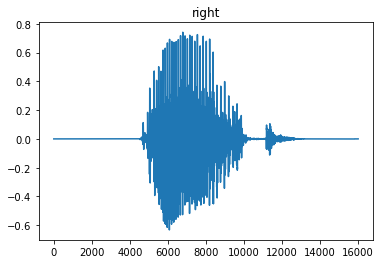

Label: right


In [21]:
print("Shape of original waveform: {}".format(waveform.size()))
print("Sample rate of origwaveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy())
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(waveform.numpy(), rate=sample_rate)

Shape of resampled waveform: torch.Size([1, 8000])


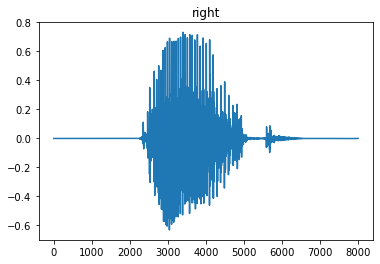

Label: right


In [22]:
# the actual resampled waveform passed to the neural network
waveform_resampled = transform(waveform)
print("Shape of resampled waveform: {}".format(waveform_resampled.size()))

plt.plot(waveform_resampled.t().numpy())
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(waveform_resampled.numpy(), rate=resample_rate)

In [23]:
# load some results

In [24]:
import pickle

In [25]:
# load some results
# get a sample audio and label
# play adversarial audio and show prediction

In [26]:
# type of results to look at
attack_name = ['L2CarliniWagner', 'LinfPGD'][1]
model_name = 'fgn_f_model_converted_long_retraining'
model = fgn_model_converted_long_retraining


# load the right batch based on index
#     number of samples in the first batch: (18, 3072, 1, 8000)
#     number of samples in the second batch: (18, 3072, 1, 8000)
#     number of samples in the third batch: (18, 3837, 1, 8000)
#     total number of samples: 9981

if idx<3072:
    batch_name = 'start_0_stop_24'
    batch_idx = idx
elif idx>=3072 and idx<3072*2:
    batch_name = 'start_24_stop_48'
    batch_idx = idx-3072
else:
    batch_name = 'start_48_stop_None'
    batch_idx = idx-3072*2

# paths to load
paths_to_load = [p for p in all_attack_results 
                 if (attack_name in p 
                     and model_name in p
                     and batch_name in p)]

In [27]:
paths_to_load

['/scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_clipped_start_0_stop_24.pickle',
 '/scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_raw_start_0_stop_24.pickle',
 '/scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_success_start_0_stop_24.pickle']

In [28]:
# load the two pickles we care about
for p in paths_to_load:
    if 'adv_raw' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_raw = pickle.load(f)
    if 'adv_success' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_success = pickle.load(f)
    if 'adv_clipped' in p:
        print('loading:', p)
        with open(p, 'rb') as f:
            results_adv_clipped = pickle.load(f)

loading: /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_clipped_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_raw_start_0_stop_24.pickle
loading: /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_converted_long_retraining_adv_success_start_0_stop_24.pickle


In [29]:
results_adv_clipped.shape

(18, 3072, 1, 8000)

In [30]:
# look at the adversarial waveform
# there are 18 espilons tested
epsilon_idx = 1
adv_waveform = results_adv_clipped[epsilon_idx][batch_idx]

In [31]:
# adv raw is the same for each epsilon
# but only for carlini-wagner?
adv_waveform_1 = results_adv_raw[0][batch_idx]
adv_waveform_2 = results_adv_raw[-1][batch_idx]
print(adv_waveform_1-adv_waveform_2)

[[-1.28527558  0.40160131  1.16894066 ... -1.37743471 -0.96801521
  -1.0581603 ]]


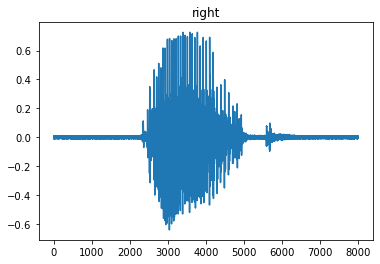

Label: right


In [32]:
plt.plot(adv_waveform.T)
plt.title(label)
plt.show()

print('Label:',label)
ipd.Audio(adv_waveform, rate=resample_rate)

In [33]:
# verify difference in value
waveform_resampled.numpy().reshape(-1) - adv_waveform.reshape(-1)

array([ 0.00434396, -0.0107884 , -0.00739145, ..., -0.00211111,
       -0.00120555,  0.00442924])

In [34]:
# what was the outcome of the attack?
# 1.0 = successful attack
results_adv_success[epsilon_idx][batch_idx]

1.0

In [35]:
# verify by running the model on the adversarial sample
output_adv = model(torch.tensor(adv_waveform).to(device).unsqueeze(0).float()).cpu().detach().numpy()
output_normal = model(torch.tensor(waveform_resampled).to(device).unsqueeze(0).float()).cpu().detach().numpy()

/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
output_adv

array([-1.55952215e+01, -2.98904018e+01, -2.33930759e+01, -3.04648857e+01,
       -3.69335632e+01, -3.51215363e+01, -3.78471642e+01, -1.96964149e+01,
       -1.98667583e+01, -8.51560116e+00, -4.62919331e+00, -3.16006832e+01,
       -3.26893921e+01, -3.52058182e+01, -8.54935646e+00, -1.02379164e-02,
       -1.41684303e+01, -2.97841682e+01, -2.69328136e+01, -1.75190792e+01,
       -2.31982803e+01, -1.07984381e+01, -1.89142494e+01, -2.72890282e+01,
       -2.05565777e+01, -2.78317490e+01, -3.18232422e+01, -3.63281670e+01,
       -4.86567993e+01, -3.30942383e+01, -2.80225487e+01, -2.00455132e+01,
       -1.19635372e+01, -1.34765558e+01, -1.90320225e+01], dtype=float32)

In [37]:
pred = np.argmax(output_adv)
pred

15

In [38]:
# softmax value
softmax_output =  np.array([np.exp(x)/sum(np.exp(output_adv)) for x in output_adv])
np.round(softmax_output,decimals=2)

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
       0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  ])

In [39]:
labels[pred]

'left'

In [40]:
# compared to original prediction
output_normal = model(waveform_resampled.to(device).unsqueeze(0)).cpu().detach().numpy()

In [41]:
pred = np.argmax(output_normal)
pred

22

In [42]:
# softmax value
softmax_output =  np.array([np.exp(x)/sum(np.exp(output_normal)) for x in output_normal])
np.round(softmax_output,decimals=2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [43]:
labels[pred]

'right'

In [44]:
# distance between the adversarial and original input
from sklearn.neighbors import DistanceMetric
l2_dist = DistanceMetric.get_metric('euclidean')
linf_dist = DistanceMetric.get_metric('chebyshev')

In [45]:
l2_dist.pairwise(adv_waveform, waveform_resampled)

array([[0.63476534]])

In [46]:
linf_dist.pairwise(adv_waveform, waveform_resampled)

array([[0.0107885]])

In [47]:
# max distance allowed based on epsilon
# precomputed bounds min and max input values
min_bound = -1.3844940662384033
max_bound = 1.3773366212844849
# attack params to explore
epsilons = [(max_bound-min_bound)*x 
            for x in 
            [0.0,
             1/256,
             3/512,
             1/128,
             3/256,
             1/64,
             3/128,
             1/32,
             3/64,
             1/16,
             3/32,
             1/8,
             3/16,
             1/4,
             3/8,
             1/2,
             3/4,
             1.0,] ]

In [48]:
### are the long retrained gaussian params lower than no retrained?
# yes they are (inv covar went up)
fgn_model_converted_long_retraining.state_dict()

OrderedDict([('fgn_conv1.centers',
              tensor([[[ 0.0079,  0.0111,  0.0059,  ..., -0.0427, -0.0664, -0.0435],
                       [-0.0075, -0.0556, -0.0868,  ..., -0.0102, -0.0168, -0.0109],
                       [-0.2308,  0.0140,  0.0026,  ..., -0.0369, -0.0109, -0.0105],
                       ...,
                       [ 0.0095,  0.0403,  0.0273,  ..., -0.0060,  0.0022, -0.0070],
                       [-0.0177,  0.0004,  0.0004,  ..., -0.0616, -0.1195, -0.0249],
                       [-0.0090, -0.0135, -0.0176,  ...,  0.0104,  0.0075,  0.0136]]])),
             ('fgn_conv1.inv_covars',
              tensor([[ 0.0872,  0.0752,  0.1098,  ...,  0.0899,  0.1265,  0.1106],
                      [ 0.0550,  0.0669,  0.0746,  ...,  0.0776,  0.0826,  0.0666],
                      [ 0.5760,  0.1434,  0.1054,  ...,  0.2619,  0.1089,  0.0887],
                      ...,
                      [ 0.0611, -0.0573, -0.0488,  ...,  0.0960,  0.0608,  0.0802],
                      

In [49]:
fgn_model_converted_no_retraining.state_dict()

OrderedDict([('fgn_conv1.centers',
              tensor([[[ 6.6776e-06,  9.7353e-06,  6.3211e-06,  ..., -8.3556e-06,
                        -9.3724e-06, -1.3811e-05],
                       [ 1.0170e-05,  4.0357e-06, -3.4421e-07,  ...,  9.6011e-06,
                         4.8886e-06, -6.9571e-06],
                       [ 1.3676e-07,  1.3687e-07,  5.4270e-08,  ...,  1.8381e-07,
                         1.9369e-07, -1.8366e-07],
                       ...,
                       [-2.2388e-06, -1.9025e-06,  6.7731e-07,  ..., -7.2798e-07,
                        -3.1648e-07,  1.3574e-06],
                       [ 5.7353e-06,  4.5010e-06,  1.2871e-06,  ...,  6.8607e-07,
                        -4.8112e-06, -5.9791e-06],
                       [-3.1232e-06, -1.3029e-06,  2.1228e-06,  ..., -2.7604e-06,
                        -4.6681e-07, -2.8365e-06]]])),
             ('fgn_conv1.inv_covars',
              tensor([[ 1.6565e-05,  8.7755e-06,  4.5105e-06,  ...,  1.6871e-05,
                

In [50]:
# num sucess
len(results_adv_success[0])

3072

In [51]:
for esp_ind, eps in enumerate(epsilons):
    total = len(results_adv_success[esp_ind])
    succ = int(sum(results_adv_success[esp_ind]))
                
    print('{}/{} = {:2f}% fooling attacks'.format(succ, total, succ/total))

446/3072 = 0.145182% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks
3072/3072 = 1.000000% fooling attacks


In [52]:
### how do the models do on noise

In [53]:
import numpy as np

In [54]:
def gen_white_noise(sample_len):
#     sample = np.random.normal(loc=0, scale=0.33, size=(1,sample_len))
    factor = 0.66e0
    sample = np.random.uniform(low=factor*min_bound, high=factor*max_bound, size=(1,sample_len))
    return(sample)

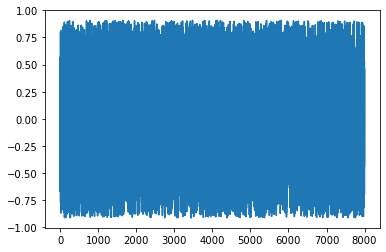

In [55]:
random_waveform = gen_white_noise(8000)
plt.plot(random_waveform.T)
plt.show()

ipd.Audio(random_waveform, rate=8000, normalize=False)

In [56]:
model = fgn_model_converted_long_retraining

In [57]:
output_random = model(torch.tensor(random_waveform).to(device).unsqueeze(0).float()).cpu().detach().numpy()

In [58]:
output_random

array([-4.5718775, -2.8340495, -5.59838  , -2.3426168, -3.076116 ,
       -1.7710879, -5.717722 , -2.698927 , -4.6208506, -6.6593733,
       -4.891045 , -4.378664 , -4.7860146, -4.360038 , -7.7126656,
       -5.8331366, -4.032172 , -3.3617902, -4.148411 , -2.3410814,
       -1.6644738, -4.5614614, -6.87846  , -3.9604099, -5.7311296,
       -5.243704 , -4.1382318, -6.9724617, -6.1590567, -3.6500583,
       -4.486805 , -6.9856462, -4.3169255, -3.857239 , -5.480796 ],
      dtype=float32)

In [59]:
pred = np.argmax(output_random)
pred

20

In [60]:
# softmax value
softmax_output =  [np.exp(x)/sum(np.exp(output_random)) for x in output_random]
np.round(softmax_output,decimals=2)

array([0.01, 0.06, 0.  , 0.1 , 0.05, 0.17, 0.  , 0.07, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.03, 0.02, 0.1 , 0.19, 0.01,
       0.  , 0.02, 0.  , 0.01, 0.02, 0.  , 0.  , 0.03, 0.01, 0.  , 0.01,
       0.02, 0.  ])

In [61]:
print(max(softmax_output))

0.1892902433763794


In [62]:
### test models on white noise (explores the entire space more or less)
# plot histogram 

In [63]:
def gen_white_noise_samples(num_samples, sample_len):
    # samples = np.random.normal(loc=0, scale=3.33, size=(num_samples,1,sample_len))
    factor = 1.0e6
    samples = np.random.uniform(low=factor*min_bound, high=factor*max_bound, size=(num_samples,1,sample_len))

    return(samples)

In [64]:
def eval_model_on_noise(model, device, num_samples, sample_len):
    # gen noise
    noise_samples = gen_white_noise_samples(num_samples, sample_len)
    # compute outputs
    with torch.no_grad():
        outputs = model(torch.tensor(noise_samples).to(device).float()).detach().cpu().numpy()
    # compute max_pred (max of softmaxs) aka the confidence of each pred
    max_preds = [max([np.exp(x)/sum(np.exp(output)) for x in output]) for output in outputs]
    
    return(max_preds)

In [65]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

In [66]:
def eval_model_on_samples(model, device, num_samples):
    # gen samples from data
    
    samples = pad_sequence([transform(val_loader.dataset[np.random.randint(9981, size=1)[0]][0]) for _ in range(num_samples)])
    
    with torch.no_grad():
        outputs = model(torch.tensor(samples).to(device).float()).detach().cpu().numpy()
    # compute max_pred (max of softmaxs) aka the confidence of each pred
    max_preds = [max([np.exp(x)/sum(np.exp(output)) for x in output]) for output in outputs]
    
    return(max_preds)

In [67]:
from scipy import stats

In [68]:
plt.rcParams['figure.figsize'] = [5, 5]

Classic
DescribeResult(nobs=30, minmax=(1.0, 1.0), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
percentage of confident (>0.5) predictions: 1.0


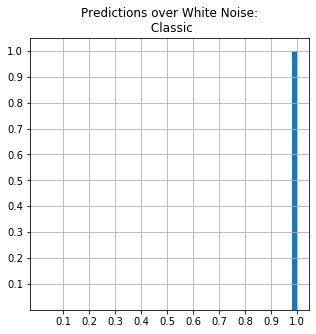

FGN_from_scratch
DescribeResult(nobs=30, minmax=(0.17060642378375673, 0.17060642378375673), mean=0.17060642378375673, variance=0.0, skewness=0.0, kurtosis=-3.0)
percentage of confident (>0.5) predictions: 0.0


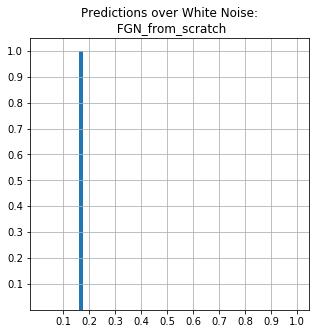

FGN_converted (no retraining)
DescribeResult(nobs=30, minmax=(0.050187398949526674, 0.050187398949526674), mean=0.05018739894952669, variance=1.9923413217798993e-34, skewness=-1.0, kurtosis=-2.0)
percentage of confident (>0.5) predictions: 0.0


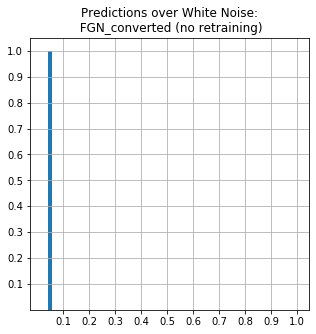

FGN_converted (fast retraining)
DescribeResult(nobs=30, minmax=(0.05006955139680842, 0.05006955139680842), mean=0.050069551396808416, variance=4.980853304449748e-35, skewness=1.0, kurtosis=-2.0)
percentage of confident (>0.5) predictions: 0.0


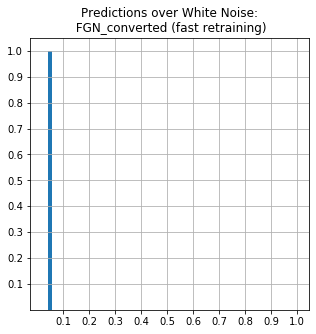

FGN_converted (long retraining)
DescribeResult(nobs=30, minmax=(0.11373921427323923, 0.11373921427323923), mean=0.11373921427323926, variance=7.969365287119597e-34, skewness=-1.0, kurtosis=-2.0)
percentage of confident (>0.5) predictions: 0.0


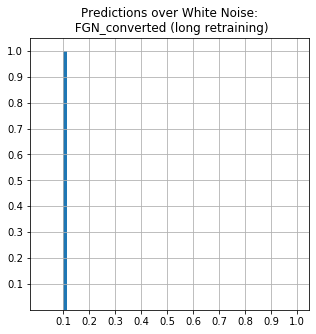

In [69]:
for model_name, model in model_name_pairs.items():
    print(model_name)
    
    model_confidences = eval_model_on_noise(model, device, 30, 8000)
    
    # quick description of the maxes
    print(stats.describe(model_confidences))
    # % of maxes above 0.5
    print("percentage of confident (>0.5) predictions:",float(len([x for x in model_confidences if x>=0.5])/float(len(model_confidences))))

    # histogram
    weights = np.ones_like(model_confidences)/len(model_confidences)
    plt.hist(model_confidences, bins=(np.arange(51)+1)/51.0, rwidth=0.8, align='mid', weights=weights)
    plt.xticks((np.arange(10)+1)/10.0)
    plt.yticks((np.arange(10)+1)/10.0)

    plt.grid(True)
    plt.title("Predictions over White Noise:\n {}".format(model_name))
    plt.show()

Classic


/home/apps/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


DescribeResult(nobs=3000, minmax=(0.04597772032709436, 0.9999999999243581), mean=0.8665772090237057, variance=0.05000048597553313, skewness=-1.9334720745129936, kurtosis=2.9760153700757623)
percentage of confident (>0.5) predictions: 0.906


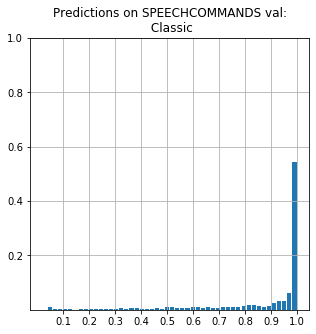

FGN_from_scratch
DescribeResult(nobs=3000, minmax=(0.05335750575101059, 0.9999999991695654), mean=0.8452617530959973, variance=0.054234810097905164, skewness=-1.6355863884475836, kurtosis=1.7078649294307384)
percentage of confident (>0.5) predictions: 0.886


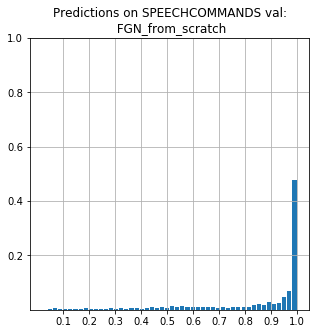

FGN_converted (no retraining)
DescribeResult(nobs=3000, minmax=(0.044589658926684726, 0.9999999999811555), mean=0.8727238157465282, variance=0.04811677806266526, skewness=-2.006953131330222, kurtosis=3.3046710109541797)
percentage of confident (>0.5) predictions: 0.9126666666666666


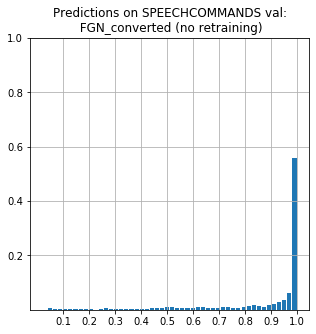

FGN_converted (fast retraining)
DescribeResult(nobs=3000, minmax=(0.04357326750626767, 0.9999999999962741), mean=0.8777835316773301, variance=0.04646088827694982, skewness=-2.0912525450409114, kurtosis=3.7248847521616764)
percentage of confident (>0.5) predictions: 0.9146666666666666


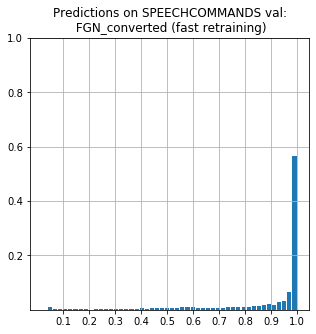

FGN_converted (long retraining)
DescribeResult(nobs=3000, minmax=(0.045750206007629086, 0.999999999997728), mean=0.8914759910019966, variance=0.042081355880549544, skewness=-2.2044808265584166, kurtosis=4.1999875389229695)
percentage of confident (>0.5) predictions: 0.923


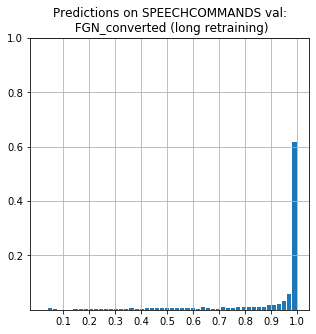

In [70]:
# pred over data
for model_name, model in model_name_pairs.items():
    print(model_name)
    
    model_confidences = eval_model_on_samples(model, device, 3000)
    
    # quick description of the maxes
    print(stats.describe(model_confidences))
    # % of maxes above 0.5
    print("percentage of confident (>0.5) predictions:",float(len([x for x in model_confidences if x>=0.5])/float(len(model_confidences))))

    # histogram
    weights = np.ones_like(model_confidences)/len(model_confidences)
    plt.hist(model_confidences, bins=(np.arange(51)+1)/51.0, rwidth=0.8, align='mid', weights=weights)
    plt.xticks((np.arange(10)+1)/10.0)
    plt.yticks((np.arange(5)+1)/5.0)
    plt.grid(True)
    plt.title("Predictions on SPEECHCOMMANDS val:\n {}".format(model_name))
    plt.show()

In [71]:
print(epsilons)

[0.0, 0.010788401123136282, 0.016182601684704423, 0.021576802246272564, 0.032365203369408846, 0.04315360449254513, 0.06473040673881769, 0.08630720898509026, 0.12946081347763538, 0.1726144179701805, 0.25892162695527077, 0.345228835940361, 0.5178432539105415, 0.690457671880722, 1.035686507821083, 1.380915343761444, 2.071373015642166, 2.761830687522888]


In [97]:
### full plots

In [98]:
# values to iterate over
attacks_name = ['L2CarliniWagner', 'LinfPGD']
model_name_to_path_name = {'Classic': 'classic_f_model',
                           'FGN_from_scratch': 'fgn_f_model_from_scratch',
                           'FGN_converted (no retraining)': 'fgn_f_model_converted_no_retraining',
                           'FGN_converted (fast retraining)': 'fgn_f_model_converted_fast_retraining',
                           'FGN_converted (long retraining)': 'fgn_f_model_converted_long_retraining'
                          }

batch_names_indices_pairs = [('start_0_stop_24', 0, 3071),
                             ('start_24_stop_48', 3072, 6143), 
                             ('start_48_stop_None', 6144, 9980)]

In [ ]:
# dicts to build 
conf_wrongs = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
conf_rights = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
low_confs = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
orig_preds_labels = {m:[] for m in model_name_to_path_name.keys()}
adv_confidences = {a:{m:[[] for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}

for batch_name, start_idx, end_idx in batch_names_indices_pairs:
    print('working on batch', batch_name)
    print('start end indices', start_idx, end_idx)

    # original label and waveforms
    batch_orig_labels = []
    batch_orig_samples = []
    for val_set_index in trange(start_idx, end_idx+1):
        waveform, _, label, _, _ = val_set[val_set_index]
        batch_orig_labels.append(label)
        batch_orig_samples.append(transform(waveform))
    batch_orig_samples = pad_sequence(batch_orig_samples).to(device)
        
    for model_name, model_path in list(model_name_to_path_name.items()):
        print('\t working on model', model_name)
        model = model_name_pairs[model_name]
        
        # original evals
        with torch.no_grad():
            batch_orig_model_preds = model(batch_orig_samples)
        batch_orig_preds_softmax = F.softmax(batch_orig_model_preds, dim=-1)
        batch_orig_preds_confidences, batch_orig_preds_labels_index = torch.max(batch_orig_preds_softmax, dim=-1)
        batch_orig_preds_labels = [labels[l] for l in batch_orig_preds_labels_index.numpy()]
        orig_preds_labels[model_name] +=  batch_orig_preds_labels
        
        # attacks
        for attack_name in attacks_name:
            print('\t\t working on attack', attack_name)

            # load a batch of adv
            path_to_load = [p for p in all_attack_results 
                            if (attack_name in p 
                                and model_path in p
                                and batch_name in p
                                and 'adv_clipped' in p
                               )]
            assert(len(path_to_load)==1)
            path_to_load=path_to_load[0]
            print('\t\t loading', path_to_load)
            with open(path_to_load, 'rb') as f:
                batch_adv_samples = pickle.load(f)
            
            for eps_ind, eps in list(enumerate(epsilons)):
                print('\t\t\t working on epsilon', eps, len(batch_adv_samples[eps_ind]))

                # don't recompute for epsilon==0
                if eps==0.0:
                    batch_adv_preds_labels = batch_orig_preds_labels
                    batch_adv_preds_confidences = batch_orig_preds_confidences
                else:
                    # eval
                    with torch.no_grad():
                        batch_adv_model_preds = model(torch.tensor(batch_adv_samples[eps_ind]).to(device).float())
                    batch_adv_preds_softmax = F.softmax(batch_adv_model_preds, dim=-1)
                    batch_adv_preds_confidences, batch_adv_preds_labels = torch.max(batch_adv_preds_softmax, dim=-1)
                    batch_adv_preds_labels = [labels[l] for l in batch_adv_preds_labels.numpy()]
                    batch_adv_preds_confidences = batch_adv_preds_confidences.numpy()

                # tally up
                confidently_right = 0
                confidently_wrong = 0
                originaly_wrong = 0
                low_confidence = 0
                assert(len(batch_orig_labels)==len(batch_orig_preds_labels))
                assert(len(batch_adv_preds_labels)==len(batch_adv_preds_confidences))
                assert(len(batch_orig_labels)==len(batch_adv_preds_confidences))
                for (orig_label, 
                     orig_pred_label, 
                     adv_pred_label, 
                     adv_pred_conf) in zip(batch_orig_labels,
                                           batch_orig_preds_labels,
                                           batch_adv_preds_labels,
                                           batch_adv_preds_confidences):
                    # only look at cases where original model was correct
                    if orig_label == orig_pred_label:
                        if adv_pred_conf>=0.5:
                            if orig_label==adv_pred_label:
                                confidently_right+=1
                            else:
                                confidently_wrong+=1
                        else:
                            low_confidence+=1
                    else:
                        originaly_wrong+=1

                print('\t\t\t confidently right:', confidently_right)
                print('\t\t\t confidently wrong:', confidently_wrong)
                print('\t\t\t originaly wrong:', originaly_wrong)
                print('\t\t\t low confidence:', low_confidence)

                # check orig wrong match

                conf_wrongs[attack_name][model_name][eps_ind] += confidently_wrong
                conf_rights[attack_name][model_name][eps_ind] += confidently_right
                low_confs[attack_name][model_name][eps_ind] += low_confidence
                adv_confidences[attack_name][model_name][eps_ind]+= batch_adv_preds_confidences.tolist()
                

working on batch start_0_stop_24
start end indices 0 3071



	 working on model Classic
		 working on attack L2CarliniWagner
		 loading /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_classic_f_model_adv_clipped_start_0_stop_24.pickle
			 working on epsilon 0.0 3072
			 confidently right: 2534
			 confidently wrong: 0
			 originaly wrong: 443
			 low confidence: 95
			 working on epsilon 0.010788401123136282 3072
			 confidently right: 1892
			 confidently wrong: 261
			 originaly wrong: 443
			 low confidence: 476
			 working on epsilon 0.016182601684704423 3072
			 confidently right: 1646
			 confidently wrong: 416
			 originaly wrong: 443
			 low confidence: 567
			 working on epsilon 0.021576802246272564 3072
			 confidently right: 1446
			 confidently wrong: 545
			 originaly wrong: 443
			 low confidence: 638
			 working on epsilon 0.032365203369408846 3072
			 confidently right: 1205
			 confidently wrong: 726
			 originaly wrong: 443
			 low confidence: 698
			 working on epsilon 0.04315360449254513 3072
			 confidently 

			 confidently right: 0
			 confidently wrong: 1352
			 originaly wrong: 536
			 low confidence: 1184
			 working on epsilon 2.761830687522888 3072
			 confidently right: 0
			 confidently wrong: 1352
			 originaly wrong: 536
			 low confidence: 1184
		 working on attack LinfPGD
		 loading /scratch/felix/FGN---Results/1637192331.3530319/LinfPGD_fgn_f_model_from_scratch_adv_clipped_start_0_stop_24.pickle
			 working on epsilon 0.0 3072
			 confidently right: 2413
			 confidently wrong: 0
			 originaly wrong: 536
			 low confidence: 123
			 working on epsilon 0.010788401123136282 3072
			 confidently right: 0
			 confidently wrong: 2530
			 originaly wrong: 536
			 low confidence: 6
			 working on epsilon 0.016182601684704423 3072
			 confidently right: 0
			 confidently wrong: 2536
			 originaly wrong: 536
			 low confidence: 0
			 working on epsilon 0.021576802246272564 3072
			 confidently right: 0
			 confidently wrong: 2535
			 originaly wrong: 536
			 low confidence: 1
			 working

			 confidently right: 0
			 confidently wrong: 2629
			 originaly wrong: 443
			 low confidence: 0
			 working on epsilon 1.380915343761444 3072
			 confidently right: 0
			 confidently wrong: 2629
			 originaly wrong: 443
			 low confidence: 0
			 working on epsilon 2.071373015642166 3072
			 confidently right: 0
			 confidently wrong: 2629
			 originaly wrong: 443
			 low confidence: 0
			 working on epsilon 2.761830687522888 3072
			 confidently right: 0
			 confidently wrong: 2629
			 originaly wrong: 443
			 low confidence: 0
	 working on model FGN_converted (fast retraining)
		 working on attack L2CarliniWagner
		 loading /scratch/felix/FGN---Results/1637192331.3530319/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_clipped_start_0_stop_24.pickle
			 working on epsilon 0.0 3072
			 confidently right: 2511
			 confidently wrong: 0
			 originaly wrong: 476
			 low confidence: 85
			 working on epsilon 0.010788401123136282 3072
			 confidently right: 1930
			 confidently 

			 confidently right: 36
			 confidently wrong: 1927
			 originaly wrong: 446
			 low confidence: 663
			 working on epsilon 0.5178432539105415 3072
			 confidently right: 19
			 confidently wrong: 1943
			 originaly wrong: 446
			 low confidence: 664
			 working on epsilon 0.690457671880722 3072
			 confidently right: 17
			 confidently wrong: 1946
			 originaly wrong: 446
			 low confidence: 663
			 working on epsilon 1.035686507821083 3072
			 confidently right: 2
			 confidently wrong: 1957
			 originaly wrong: 446
			 low confidence: 667
			 working on epsilon 1.380915343761444 3072
			 confidently right: 0
			 confidently wrong: 1962
			 originaly wrong: 446
			 low confidence: 664
			 working on epsilon 2.071373015642166 3072
			 confidently right: 0
			 confidently wrong: 1962
			 originaly wrong: 446
			 low confidence: 664
			 working on epsilon 2.761830687522888 3072
			 confidently right: 0
			 confidently wrong: 1962
			 originaly wrong: 446
			 low confidence: 664
		 wor

In [5]:
for k1 in ['L2CarliniWagner', 'LinfPGD']:
    print(k1)
    for k2 in ['Classic', 'FGN_from_scratch', 'FGN_converted (no retraining)','FGN_converted (fast retraining)','FGN_converted (long retraining)']:
        print('\t',k2)
        print('\t',conf_rights[k1][k2])

L2CarliniWagner
	 Classic
	 [8465, 6644, 5920, 5315, 4603, 4001, 3089, 2436, 1605, 989, 449, 298, 157, 99, 8, 0, 0, 0]
	 FGN_from_scratch
	 [8166, 6112, 5390, 4819, 4046, 3537, 2766, 2172, 1313, 854, 440, 323, 177, 119, 9, 0, 0, 0]
	 FGN_converted (no retraining)
	 [8465, 7339, 6869, 6514, 6064, 5682, 5130, 4717, 4206, 3836, 3528, 3419, 3313, 3227, 3118, 3019, 2933, 2753]
	 FGN_converted (fast retraining)
	 [8346, 7305, 6858, 6467, 5894, 5535, 4924, 4534, 4061, 3718, 3453, 3336, 3242, 3156, 3076, 2986, 2914, 2775]
	 FGN_converted (long retraining)
	 [8490, 6452, 5637, 4991, 4231, 3687, 2802, 2183, 1323, 603, 228, 152, 74, 50, 5, 0, 0, 0]
LinfPGD
	 Classic
	 [8384, 3152, 3106, 3008, 2907, 2710, 2529, 2080, 1722, 1217, 855, 439, 271, 112, 48, 14, 5, 0]
	 FGN_from_scratch
	 [8065, 3009, 2967, 2887, 2775, 2574, 2325, 1894, 1578, 1118, 807, 438, 249, 111, 36, 4, 0, 0]
	 FGN_converted (no retraining)
	 [8465, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	 FGN_converted (fast retraining

In [6]:
for k1 in ['L2CarliniWagner', 'LinfPGD']:
    print(k1)
    for k2 in ['Classic', 'FGN_from_scratch', 'FGN_converted (no retraining)','FGN_converted (fast retraining)','FGN_converted (long retraining)']:
        print('  ',k2)
        print('    ',conf_wrongs[k1][k2])

L2CarliniWagner
   Classic
     [0, 767, 1243, 1637, 2143, 2584, 3291, 3823, 4532, 5102, 5581, 5719, 5817, 5861, 5909, 5922, 5922, 5922]
   FGN_from_scratch
     [0, 783, 1153, 1509, 1968, 2282, 2823, 3258, 3919, 4306, 4631, 4735, 4813, 4859, 4925, 4941, 4941, 4941]
   FGN_converted (no retraining)
     [0, 448, 744, 977, 1309, 1599, 2022, 2362, 2789, 3140, 3410, 3498, 3554, 3607, 3656, 3702, 3735, 3814]
   FGN_converted (fast retraining)
     [0, 413, 688, 939, 1373, 1682, 2189, 2533, 2952, 3252, 3495, 3589, 3661, 3701, 3744, 3789, 3816, 3883]
   FGN_converted (long retraining)
     [0, 1097, 1718, 2222, 2833, 3276, 4054, 4597, 5384, 6075, 6444, 6512, 6582, 6603, 6638, 6646, 6646, 6646]
LinfPGD
   Classic
     [36, 5412, 5449, 5507, 5587, 5748, 5923, 6346, 6731, 7289, 7679, 8174, 8383, 8587, 8670, 8729, 8732, 8750]
   FGN_from_scratch
     [26, 5303, 5328, 5407, 5472, 5625, 5834, 6220, 6547, 7083, 7417, 7873, 8139, 8353, 8449, 8522, 8545, 8561]
   FGN_converted (no retraining)
     [0

In [7]:
for k1 in ['L2CarliniWagner', 'LinfPGD']:
    print(k1)
    for k2 in ['Classic', 'FGN_from_scratch', 'FGN_converted (no retraining)','FGN_converted (fast retraining)','FGN_converted (long retraining)']:
        print('  ',k2)
        print('    ',low_confs[k1][k2])

L2CarliniWagner
   Classic
     [288, 1342, 1590, 1801, 2007, 2168, 2373, 2494, 2616, 2662, 2723, 2736, 2779, 2793, 2836, 2831, 2831, 2831]
   FGN_from_scratch
     [404, 1675, 2027, 2242, 2556, 2751, 2981, 3140, 3338, 3410, 3499, 3512, 3580, 3592, 3636, 3629, 3629, 3629]
   FGN_converted (no retraining)
     [288, 966, 1140, 1262, 1380, 1472, 1601, 1674, 1758, 1777, 1815, 1836, 1886, 1919, 1979, 2032, 2085, 2186]
   FGN_converted (fast retraining)
     [306, 934, 1106, 1246, 1385, 1435, 1539, 1585, 1639, 1682, 1704, 1727, 1749, 1795, 1832, 1877, 1922, 1994]
   FGN_converted (long retraining)
     [234, 1175, 1369, 1511, 1660, 1761, 1868, 1944, 2017, 2046, 2052, 2060, 2068, 2071, 2081, 2078, 2078, 2078]
LinfPGD
   Classic
     [333, 189, 198, 238, 259, 295, 301, 327, 300, 247, 219, 140, 99, 54, 35, 10, 16, 3]
   FGN_from_scratch
     [479, 258, 275, 276, 323, 371, 411, 456, 445, 369, 346, 259, 182, 106, 85, 44, 25, 9]
   FGN_converted (no retraining)
     [288, 5, 2, 0, 0, 1, 0, 1, 0, 

In [3]:
save_results_dir = '/scratch/felix/FGN---Results/cw_pgd_results_normal_epsilon/'

In [1]:
import json

In [ ]:
with open(save_results_dir+'/conf_wrongs.json', 'w', encoding ='utf8') as f:
    json.dump(conf_wrongs, f, ensure_ascii = True)
    
with open(save_results_dir+'/conf_rights.json', 'w', encoding ='utf8') as f:
    json.dump(conf_rights, f, ensure_ascii = True)

with open(save_results_dir+'/low_confs.json', 'w', encoding ='utf8') as f:
    json.dump(low_confs, f, ensure_ascii = True)

with open(save_results_dir+'/adv_confidences.json', 'w', encoding ='utf8') as f:
    json.dump(adv_confidences_copy, f, ensure_ascii = True)

In [78]:
# check when those files were modified
from os.path import getmtime
import datetime

In [82]:
timestamp = getmtime(attack_results_dir+'/low_confs.json')
value = datetime.datetime.fromtimestamp(timestamp)
print(value.strftime('%Y-%m-%d %H:%M:%S'))

2022-05-25 17:11:40


In [4]:
# reload
with open(attack_results_dir+'/conf_wrongs.json', 'r') as f:
    conf_wrongs = json.load(f)
    
with open(attack_results_dir+'/conf_rights.json', 'r') as f:
    conf_rights = json.load(f)
    
with open(attack_results_dir+'/low_confs.json', 'r') as f:
    low_confs = json.load(f)

with open(attack_results_dir+'/adv_confidences.json', 'r') as f:
    adv_confidences = json.load(f)

In [ ]:
# empty files to recompute

# /scratch/felix/FGN---Results/1637433413.7582006/LinfPGD_fgn_f_model_converted_fast_retraining_adv_clipped_start_24_stop_48.pickle
# /scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_fgn_f_model_converted_fast_retraining_adv_clipped_start_48_stop_None.pickle
# /scratch/felix/FGN---Results/1637624970.2306073/L2CarliniWagner_fgn_f_model_converted_no_retraining_adv_clipped_start_48_stop_None.pickle
# /scratch/felix/FGN---Results/1637624970.2306073/LinfPGD_classic_f_model_adv_raw_start_48_stop_None.pickle
# /scratch/felix/FGN---Results/1637624970.2306073/LinfPGD_fgn_f_model_from_scratch_adv_clipped_start_48_stop_None.pickle

In [69]:
##################################
### study for smaller espilons ###
##################################

In [70]:
epsilons = [(max_bound-min_bound)*x*(1./256.) 
            for x in 
            [1./512,
             3./1024,
             1./256,
             3./512,
             1./128,
             3./256,
             1./64,
             3./128,
             1./32,
             3./64,
             1./16,
             3./32,
             1./8,
             3./16,
             1./4,
             3./8,
             1./2,
             3./4,
            ] ]

print(epsilons)

[2.107109594362555e-05, 3.1606643915438326e-05, 4.21421918872511e-05, 6.321328783087665e-05, 8.42843837745022e-05, 0.0001264265756617533, 0.0001685687675490044, 0.0002528531513235066, 0.0003371375350980088, 0.0005057063026470132, 0.0006742750701960176, 0.0010114126052940264, 0.0013485501403920352, 0.002022825210588053, 0.0026971002807840705, 0.004045650421176106, 0.005394200561568141, 0.008091300842352211]


In [71]:
### small epsilon attacks
attack_results_dir = '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon'
attack_results_dir_list = sorted(glob.glob(attack_results_dir+'/*', recursive = True))
all_attack_results = attack_results_dir_list

In [72]:
len(sorted(all_attack_results))
# should be
# 2 attacks * 5 models * 4 batches * 3 types(clipped raw success)= 120

120

In [73]:
all_attack_results

['/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_0_stop_16.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_16_stop_32.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_32_stop_48.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_48_stop_None.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_raw_start_0_stop_16.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_raw_start_16_stop_32.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_raw_start_32_stop_48.pickle',
 '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_raw_st

In [74]:
attacks_name = ['L2CarliniWagner', 'LinfPGD']
model_name_to_path_name = {'Classic': 'classic_f_model',
                           'FGN_from_scratch': 'fgn_f_model_from_scratch',
                           'FGN_converted (no retraining)': 'fgn_f_model_converted_no_retraining',
                           'FGN_converted (fast retraining)': 'fgn_f_model_converted_fast_retraining',
                           'FGN_converted (long retraining)': 'fgn_f_model_converted_long_retraining'
                          }
batch_names_indices_pairs = [('start_0_stop_16', 0, 2048),
                             ('start_16_stop_32', 2048, 4096), 
                             ('start_32_stop_48', 4096, 6144),
                             ('start_48_stop_None', 6144, 9981)]

In [78]:
#### dicts to build 
conf_wrongs = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
conf_rights = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
low_confs = {a:{m:[0 for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}
orig_preds_labels = {m:[] for m in model_name_to_path_name.keys()}
adv_confidences = {a:{m:[[] for _ in range(len(epsilons))] 
                 for m in model_name_to_path_name.keys()}
              for a in attacks_name}

for batch_name, start_idx, end_idx in batch_names_indices_pairs[3:]:
    print('working on batch', batch_name)
    print('start end indices', start_idx, end_idx)

    # original label and waveforms
    batch_orig_labels = []
    batch_orig_samples = []
    for val_set_index in trange(start_idx, end_idx):
        waveform, _, label, _, _ = val_set[val_set_index]
        batch_orig_labels.append(label)
        batch_orig_samples.append(transform(waveform))
    batch_orig_samples = pad_sequence(batch_orig_samples).to(device)
        
    for model_name, model_path in list(model_name_to_path_name.items()):
        print('\t working on model', model_name)
        model = model_name_pairs[model_name]
        
        # original evals
        with torch.no_grad():
            batch_orig_model_preds = model(batch_orig_samples)
        batch_orig_preds_softmax = F.softmax(batch_orig_model_preds, dim=-1)
        batch_orig_preds_confidences, batch_orig_preds_labels_index = torch.max(batch_orig_preds_softmax, dim=-1)
        batch_orig_preds_labels = [labels[l] for l in batch_orig_preds_labels_index.numpy()]
        orig_preds_labels[model_name] +=  batch_orig_preds_labels
        
        # attacks
        for attack_name in attacks_name:
            print('\t\t working on attack', attack_name)

            # load a batch of adv
            path_to_load = [p for p in all_attack_results 
                            if (attack_name in p 
                                and model_path in p
                                and batch_name in p
                                and 'adv_clipped' in p
                               )]
            assert(len(path_to_load)==1)
            path_to_load=path_to_load[0]
            print('\t\t loading', path_to_load)
            with open(path_to_load, 'rb') as f:
                batch_adv_samples = pickle.load(f)
            
            for eps_ind, eps in list(enumerate(epsilons)):
                print('\t\t\t working on epsilon', eps, len(batch_adv_samples[eps_ind]))

                # don't recompute for epsilon==0
                if eps==0.0:
                    batch_adv_preds_labels = batch_orig_preds_labels
                    batch_adv_preds_confidences = batch_orig_preds_confidences
                else:
                    # eval
                    with torch.no_grad():
                        batch_adv_model_preds = model(torch.tensor(batch_adv_samples[eps_ind]).to(device).float())
                    batch_adv_preds_softmax = F.softmax(batch_adv_model_preds, dim=-1)
                    batch_adv_preds_confidence, batch_adv_preds_labels = torch.max(batch_adv_preds_softmax, dim=-1)
                    batch_adv_preds_labels = [labels[l] for l in batch_adv_preds_labels.numpy()]
                    batch_adv_preds_confidences = batch_adv_preds_confidence.numpy()

                # tally up
                confidently_right = 0
                confidently_wrong = 0
                originaly_wrong = 0
                low_confidence = 0
                assert(len(batch_orig_labels)==len(batch_orig_preds_labels))
                assert(len(batch_adv_preds_labels)==len(batch_adv_preds_confidences))
                assert(len(batch_orig_labels)==len(batch_adv_preds_confidences))
                for (orig_label, 
                     orig_pred_label, 
                     adv_pred_label, 
                     adv_pred_conf) in zip(batch_orig_labels,
                                           batch_orig_preds_labels,
                                           batch_adv_preds_labels,
                                           batch_adv_preds_confidences):
                    # only look at cases where original model was correct
                    if orig_label == orig_pred_label:
                        if adv_pred_conf>=0.5:
                            if orig_label==adv_pred_label:
                                confidently_right+=1
                            else:
                                confidently_wrong+=1
                        else:
                            low_confidence+=1
                    else:
                        originaly_wrong+=1

                print('\t\t\t confidently right:', confidently_right)
                print('\t\t\t confidently wrong:', confidently_wrong)
                print('\t\t\t originaly wrong:', originaly_wrong)
                print('\t\t\t low confidence:', low_confidence)

                # check orig wrong match

                conf_wrongs[attack_name][model_name][eps_ind] += confidently_wrong
                conf_rights[attack_name][model_name][eps_ind] += confidently_right
                low_confs[attack_name][model_name][eps_ind] += low_confidence
                adv_confidences[attack_name][model_name][eps_ind]+= batch_adv_preds_confidences.tolist()
                

working on batch start_48_stop_None
start end indices 6144 9980



	 working on model Classic
		 working on attack L2CarliniWagner
		 loading /scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_48_stop_None.pickle
			 working on epsilon 2.107109594362555e-05 3837


AssertionError: 

In [78]:
len(list(range(0,2048)))

2048

In [79]:
len(batch_orig_labels),len(batch_adv_preds_confidences)

(3836, 3837)

In [77]:
path_to_load = '/scratch/felix/FGN---Results/cw_pgd_results_small_epsilon/L2CarliniWagner_classic_f_model_adv_clipped_start_0_stop_16.pickle'
with open(path_to_load, 'rb') as f:
    batch_adv_samples_1 = pickle.load(f)

In [81]:
val_set[9981]

IndexError: list index out of range

In [ ]:
# with open(attack_results_dir+'/conf_wrongs.json', 'w', encoding ='utf8') as f:
#     json.dump(conf_wrongs, f, ensure_ascii = True)
    
# with open(attack_results_dir+'/conf_rights.json', 'w', encoding ='utf8') as f:
#     json.dump(conf_rights, f, ensure_ascii = True)

# with open(attack_results_dir+'/low_confs.json', 'w', encoding ='utf8') as f:
#     json.dump(low_confs, f, ensure_ascii = True)

# with open(attack_results_dir+'/adv_confidences.json', 'w', encoding ='utf8') as f:
#     json.dump(adv_confidences_copy, f, ensure_ascii = True)

In [ ]:
print(conf_wrongs)

In [ ]:
# # all the params to loop over
# attack = attacks_name[0]
# model_name,model_path = list(model_name_to_path_name.items())[0]
# model = model_name_pairs[model_name]
# batch_name = batch_names[0]
# eps_ind, eps = list(enumerate(epsilons))[0]

In [ ]:
# # load a batch of adv
# path_to_load = attack_results_dir+'/'+'_'.join([attack,model_path,'adv_clipped',batch_name])+'.pickle'
# with open(path_to_load, 'rb') as f:
#     cur_adv_samples = pickle.load(f)

In [ ]:
# # original label and waveforms
# orig_labels = []
# orig_samples = []
# for i in range(start_idx,end_idx):
#     waveform, _, label, _, _ = val_set[i]
#     orig_labels.append(label)
#     orig_samples.append(transform(waveform))

In [ ]:
# orig_samples = pad_sequence(orig_samples).to(device)

In [ ]:
# # eval
# with torch.no_grad():
#     orig_model_preds = model(orig_samples)
#     adv_model_preds = model(torch.tensor(cur_adv_samples[eps_ind]).to(device).float())

In [ ]:
# orig_preds_softmax = F.softmax(orig_model_preds, dim=-1)
# adv_preds_softmax = F.softmax(adv_model_preds, dim=-1)

In [ ]:
# orig_preds_confidence, orig_preds_labels = torch.max(orig_preds_softmax, dim=-1)
# orig_preds_labels = orig_preds_labels.numpy()
# orig_preds_confidence = orig_preds_confidence.numpy()

In [ ]:
# adv_preds_confidence, adv_preds_labels = torch.max(adv_preds_softmax, dim=-1)
# adv_preds_labels = adv_preds_labels.numpy()
# adv_preds_confidence = adv_preds_confidence.numpy()

In [ ]:
# confidently_right = 0
# confidently_wrong = 0
# originaly_wrong = 0
# low_confidence = 0
# for i in range(len(orig_preds_labels)):
#     # only look at cases where original model was correct
#     if labels[orig_preds_labels[i]] == orig_labels[i]:
#         if adv_preds_confidence[i] >=0.5:
#             if orig_labels[i]==labels[adv_preds_labels[i]]:
#                 confidently_right+=1
#             else:
#                 confidently_wrong+=1
#         else:
#             low_confidence+=1
#     else:
#         originaly_wrong+=1

In [ ]:
# print('confidently right:', confidently_right)
# print('confidently wrong:', confidently_wrong)
# print('originaly wrong:', originaly_wrong)
# print('low confidence:', low_confidence)
# print(confidently_right+confidently_wrong+originaly_wrong+low_confidence)

In [ ]:
# conf_wrongs[attack_name][model_name][eps_ind] += confidently_wrong
# conf_rights[attack_name][model_name][eps_ind] += confidently_right
# adv_confidences[attack_name][model_name][eps_ind].append(adv_preds_confidence)

In [ ]:
# attack_name, model_name, esp_ind

In [ ]:
# adv_confidences[attack_name][model_name][eps_ind].append(adv_preds_confidence)

In [ ]:
# adv_confidences[attack_name][model_name][eps_ind]